In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pyro.contrib.examples.bart import load_bart_od 

In [2]:
# BART駅の1時間ごとの出発地と目的地の乗客数のデータセット(2011-2019年)
dataset = load_bart_od()

In [14]:
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


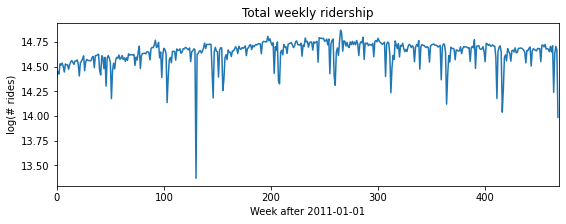

In [15]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

In [17]:
data.shape

torch.Size([469, 1])

In [327]:
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
import pyro.distributions as dist
import torch
import pyro

# ForecastingModelを継承して、Modelクラスをつくる。そして、model関数が必要
# たぶんこのモデルでは、
class Model1(ForecastingModel):

    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1) # 
        feature_dim = covariates.size(-1)  # 特徴量数
        
        bias = pyro.sample("bias", dist.Normal(0, 1).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)

        assert prediction.shape[-2:] == zero_data.shape

        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        self.predict(noise_dist, prediction)

In [324]:
T0 = 0              # begining
T2 = data.size(-2)  # end
T1 = T2 - 52        # train/test split

In [354]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
model = Model1()
forecaster = Forecaster(model, data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 1.45082e+06
INFO 	 step  100 loss = 3.73822
INFO 	 step  200 loss = -0.339163
INFO 	 step  300 loss = -0.362351
INFO 	 step  400 loss = -0.347578
INFO 	 step  500 loss = -0.358602
INFO 	 step  600 loss = -0.366867
INFO 	 step  700 loss = -0.367365
INFO 	 step  800 loss = -0.366863
INFO 	 step  900 loss = -0.352209
INFO 	 step 1000 loss = -0.364179


CPU times: user 3.44 s, sys: 1.38 ms, total: 3.44 s
Wall time: 3.44 s


torch.Size([1000, 52, 1]) torch.Size([52])


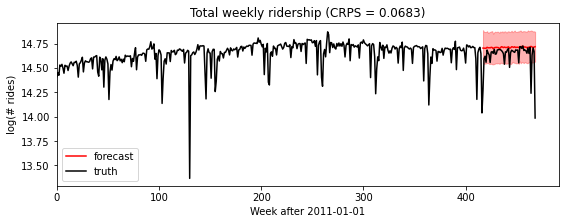

In [329]:
from pyro.ops.stats import quantile

samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

In [205]:
# 平均: 0、標準偏差: 1の分布から1回サンプリング
bias = pyro.sample("bias", dist.Normal(0, 1))
bias

tensor(0.7285)

In [234]:
# expand 次元の拡張
bias = pyro.sample("bias", dist.Normal(0, 1).expand([2]))
bias

tensor([-1.2093, -0.0512])

In [322]:
# to_eventとすることで、単変量分布を多変量分布とみなせる（従属変数とする）
# これをすることにより、多変量分布に置き換えやすくなり、また、pyro.plate(for文のかわりにpyroではこれを使う)を使う必要がなくなる。
# 要するに、ここで10個のサンプリングが独立であるということを（書かなくてもそうなのだけど、あえて）書いている
bias = pyro.sample("bias", dist.Normal(0, 1).expand([10]).to_event(1))
bias

tensor([ 0.4427,  0.2791,  0.9673, -0.7217, -0.6930,  0.3413, -0.0366, -1.2462,
         0.1379,  0.3713])

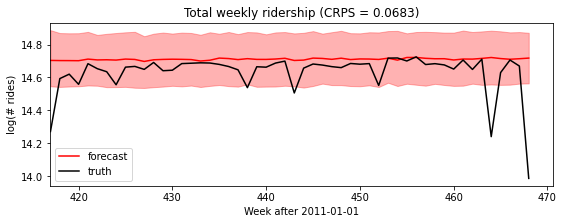

In [347]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [349]:
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features

In [350]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 7)], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 159086
INFO 	 step  100 loss = 3.39817
INFO 	 step  200 loss = 0.376945
INFO 	 step  300 loss = 0.00041467
INFO 	 step  400 loss = -0.158113
INFO 	 step  500 loss = -0.137202
INFO 	 step  600 loss = -0.296466
INFO 	 step  700 loss = -0.314957
INFO 	 step  800 loss = -0.298268
INFO 	 step  900 loss = -0.299336
INFO 	 step 1000 loss = -0.336899


CPU times: user 3.49 s, sys: 0 ns, total: 3.49 s
Wall time: 3.49 s


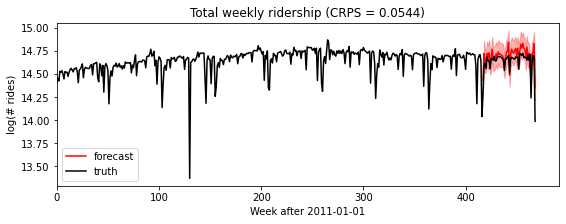

In [351]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

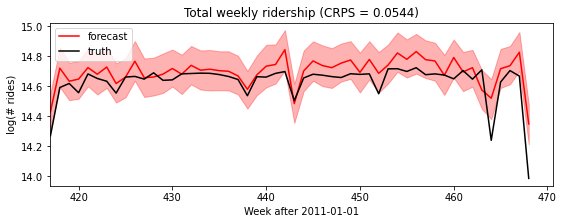

In [352]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [358]:
from pyro.infer.reparam import LocScaleReparam, StableReparam
import pyro.poutine as poutine


In [359]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        motion = drift.cumsum(-2)

        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [360]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct",
                       )

INFO 	 step    0 loss = 1.73259e+09
INFO 	 step  100 loss = 0.934739
INFO 	 step  200 loss = -0.0674358
INFO 	 step  300 loss = -0.165568
INFO 	 step  400 loss = -0.219376
INFO 	 step  500 loss = -0.344883
INFO 	 step  600 loss = -0.332985
INFO 	 step  700 loss = -0.404336
INFO 	 step  800 loss = -0.465259
INFO 	 step  900 loss = -0.513265
INFO 	 step 1000 loss = -0.506268


CPU times: user 7.18 s, sys: 0 ns, total: 7.18 s
Wall time: 7.18 s


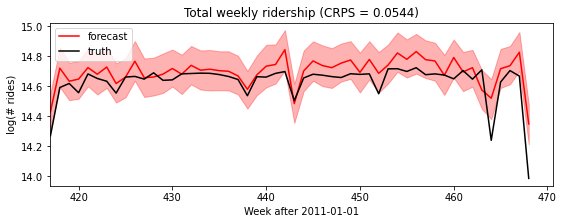

In [361]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [362]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))
        motion = drift.cumsum(-2)  # A Brownian motion.

        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale)

        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)

In [363]:
%%time
pyro.set_rng_seed(2)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct")
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 5.92061e+07
INFO 	 step  100 loss = 13.6566
INFO 	 step  200 loss = 3.0852
INFO 	 step  300 loss = 0.946547
INFO 	 step  400 loss = 0.386835
INFO 	 step  500 loss = 0.0171096
INFO 	 step  600 loss = -0.265826
INFO 	 step  700 loss = -0.331295
INFO 	 step  800 loss = -0.261613
INFO 	 step  900 loss = -0.321645
INFO 	 step 1000 loss = -0.31462


bias = 14.64
drift_scale = 1.762e-08
noise_stability = 1.937
noise_skew = 0.0007123
noise_scale = 0.05908
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s


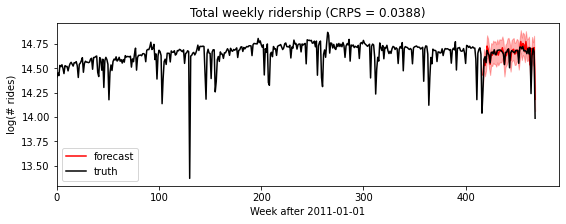

In [364]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

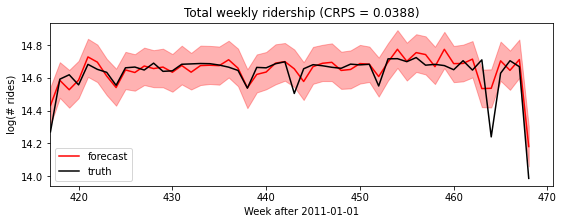

In [365]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

In [366]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows2 = backtest(data, covariates, Model2,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
INFO 	 step    0 loss = 3543.21
INFO 	 step 1000 loss = 0.129398
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 0.262129
INFO 	 step 1000 loss = -0.186021
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 0.577176
INFO 	 step 1000 loss = -0.0194702
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 0.173329
INFO 	 step 1000 loss = -0.123808
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 0.16151
INFO 	 step 1000 loss = -0.183428
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0 loss = 0.0665096
INFO 	 step 1000 loss = -0.211452
INFO 	 Training on window [0:260], testing on window [260:312]
INFO 	 step    0 loss = -0.010963
INFO 	 step 1000 loss = -0.261924
INFO 	 Training on window [0:286], testing on window [286:338]
INFO 	 step    0 loss = -0.

CPU times: user 1min 34s, sys: 1.41 ms, total: 1min 34s
Wall time: 1min 33s


In [367]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows3 = backtest(data, covariates, Model3,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
INFO 	 step    0 loss = 1852.88
INFO 	 step 1000 loss = 0.546057
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 2.5808
INFO 	 step 1000 loss = 0.133373
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 2.65537
INFO 	 step 1000 loss = 0.0920958
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 1.99651
INFO 	 step 1000 loss = 0.0499864
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 1.57991
INFO 	 step 1000 loss = -0.0995403
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0 loss = 1.29995
INFO 	 step 1000 loss = -0.11185
INFO 	 Training on window [0:260], testing on window [260:312]
INFO 	 step    0 loss = 1.23317
INFO 	 step 1000 loss = -0.20551
INFO 	 Training on window [0:286], testing on window [286:338]
INFO 	 step    0 loss = 0.983528
INFO 

CPU times: user 3min 9s, sys: 68.3 ms, total: 3min 9s
Wall time: 3min 8s


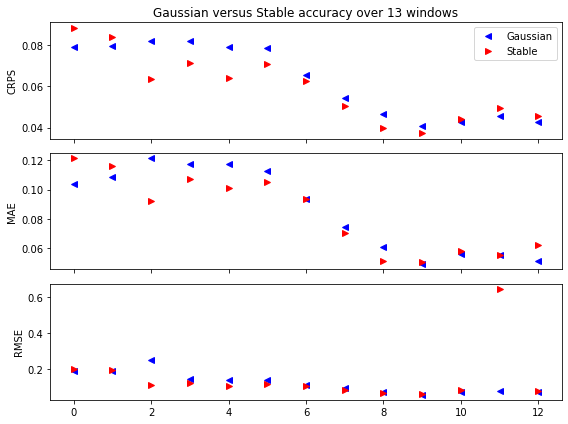

In [368]:
fig, axes = plt.subplots(3, figsize=(8, 6), sharex=True)
axes[0].set_title("Gaussian versus Stable accuracy over {} windows".format(len(windows2)))
axes[0].plot([w["crps"] for w in windows2], "b<", label="Gaussian")
axes[0].plot([w["crps"] for w in windows3], "r>", label="Stable")
axes[0].set_ylabel("CRPS")
axes[1].plot([w["mae"] for w in windows2], "b<", label="Gaussian")
axes[1].plot([w["mae"] for w in windows3], "r>", label="Stable")
axes[1].set_ylabel("MAE")
axes[2].plot([w["rmse"] for w in windows2], "b<", label="Gaussian")
axes[2].plot([w["rmse"] for w in windows3], "r>", label="Stable")
axes[2].set_ylabel("RMSE")
axes[0].legend(loc="best")
plt.tight_layout()